In [48]:
# Data Loading and Class Count
import os

train_dir = 'dataset/train'
valid_dir = 'dataset/valid'
test_dir = 'dataset/test'

# Check class names
classes = os.listdir(train_dir)
print("Classes:", classes)

# Count images per class
for cls in classes:
    print(f"{cls} - Train: {len(os.listdir(os.path.join(train_dir, cls)))}")
    print(f"{cls} - Valid: {len(os.listdir(os.path.join(valid_dir, cls)))}")
    print(f"{cls} - Test: {len(os.listdir(os.path.join(test_dir, cls)))}")



Classes: ['icecream', 'pizza']
icecream - Train: 391
icecream - Valid: 114
icecream - Test: 59
pizza - Train: 327
pizza - Valid: 94
pizza - Test: 47


Problem Statement:
-----------------
To build a CNN model to classify whether an image belongs to the 'pizza' or 'icecream' category using supervised learning.

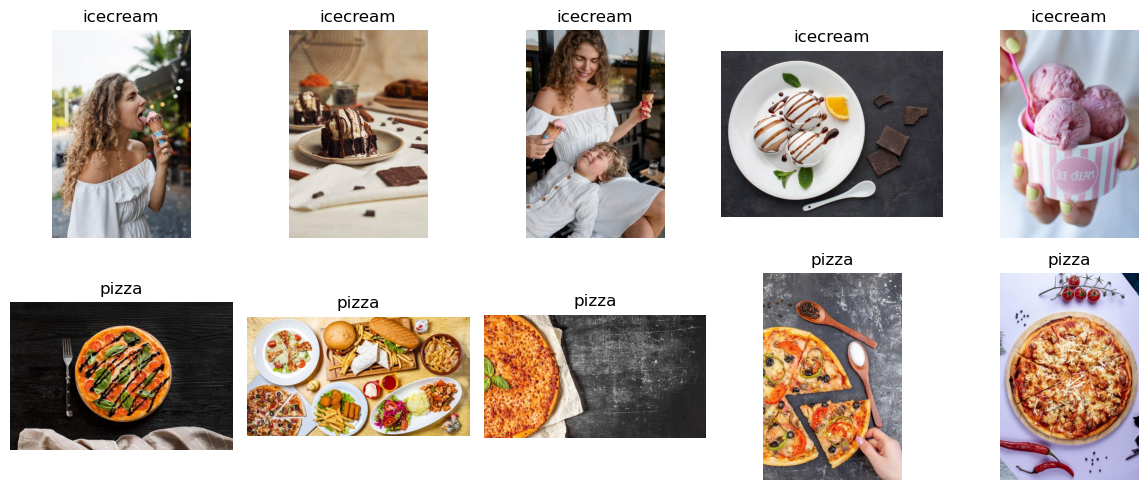

In [49]:
# Data Visualization 
import matplotlib.pyplot as plt
from PIL import Image
import os

# Show 5 sample images for each class
plt.figure(figsize=(12, 5))

for class_idx, class_name in enumerate(classes):
    sample_folder = os.path.join(train_dir, class_name)
    sample_images = os.listdir(sample_folder)[:5]

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(sample_folder, img_name)
        img = Image.open(img_path)
        plt.subplot(2, 5, class_idx * 5 + i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)

plt.tight_layout()
plt.show()


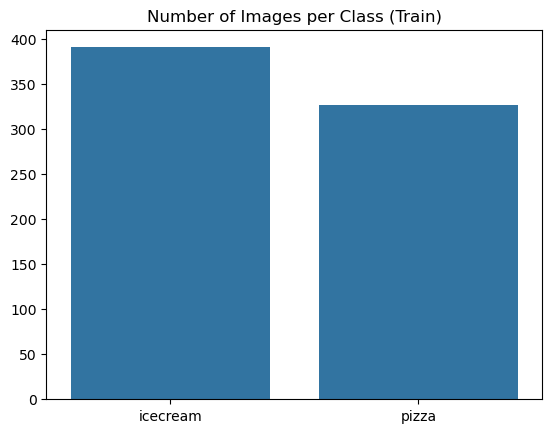

In [50]:
import seaborn as sns
import pandas as pd

# Distribution of images per class
counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Number of Images per Class (Train)")
plt.show()


In [51]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np

In [52]:
# 1. Setup
data_dir = 'dataset'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')


In [53]:
# 2. Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [54]:
# 3. Data Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [55]:
# 4. Load Data
train_data = datasets.ImageFolder(train_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [56]:
# 5. Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = CNNModel().to(device)


In [57]:
# 6. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [58]:
# 7. Training Loop
epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(valid_loader))
    accuracy = correct / total * 100

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {accuracy:.2f}%")


Epoch [1/10], Train Loss: 0.5354, Val Loss: 0.5142, Val Accuracy: 78.37%
Epoch [2/10], Train Loss: 0.3310, Val Loss: 0.2643, Val Accuracy: 88.46%
Epoch [3/10], Train Loss: 0.2429, Val Loss: 0.1940, Val Accuracy: 92.31%
Epoch [4/10], Train Loss: 0.2090, Val Loss: 0.1953, Val Accuracy: 91.83%
Epoch [5/10], Train Loss: 0.1652, Val Loss: 0.1717, Val Accuracy: 92.79%
Epoch [6/10], Train Loss: 0.0983, Val Loss: 0.1765, Val Accuracy: 93.75%
Epoch [7/10], Train Loss: 0.0629, Val Loss: 0.2096, Val Accuracy: 91.83%
Epoch [8/10], Train Loss: 0.0621, Val Loss: 0.2378, Val Accuracy: 93.75%
Epoch [9/10], Train Loss: 0.0217, Val Loss: 0.2075, Val Accuracy: 92.79%
Epoch [10/10], Train Loss: 0.0176, Val Loss: 0.2152, Val Accuracy: 95.19%


In [59]:
# 8. Final Model Evaluation on Test Set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 92.45%


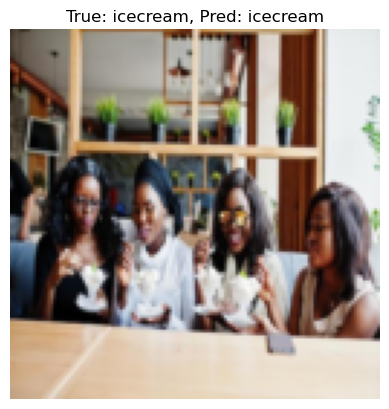

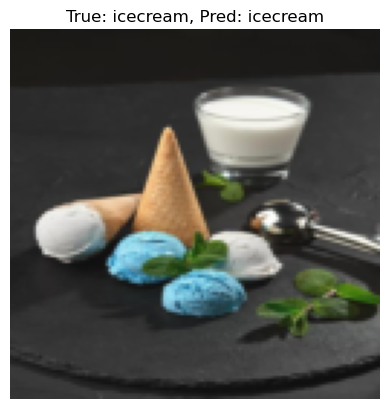

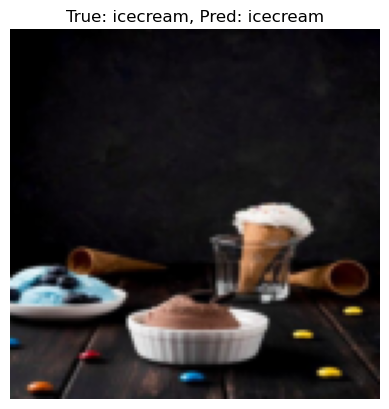

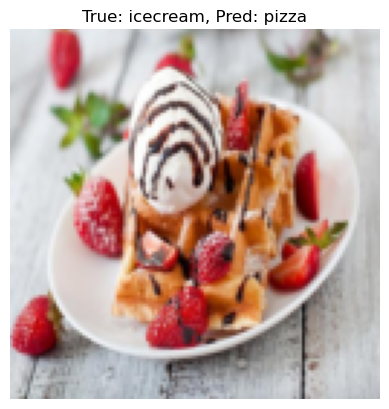

In [60]:
# 9. Sample Predictions
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

data_iter = iter(test_loader)
images, labels = next(data_iter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

for i in range(4):
    imshow(images[i], f"True: {classes[labels[i]]}, Pred: {classes[preds[i]]}")

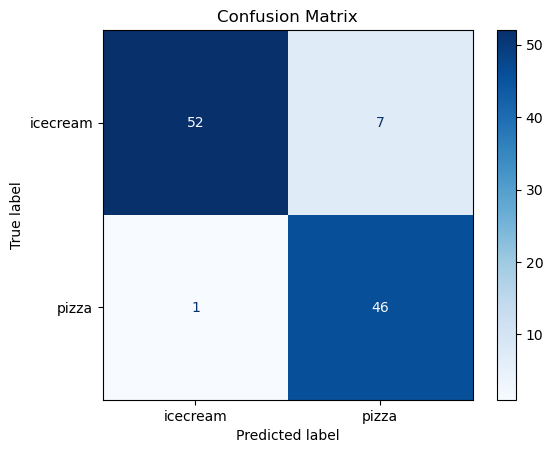

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
